# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [142]:
import numpy as np
import pandas as pd
from typing import  List

import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [146]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
669,4595,49547,She/ her,17-03-2020,Before watching #Supernatural : COVID-19 is sh...,Negative
1427,5524,50476,"Dublin City, Ireland",17-03-2020,Broke my heart today walking around the superm...,Extremely Negative
32780,44118,89070,NaN,13-04-2020,"A little something we put together recently: ""...",Positive
29753,40328,85280,"Nashville, TN",09-04-2020,@PMOIndia @nsitharaman after COVID-19 stops be...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [147]:
# -- YOUR CODE HERE --
def change_on_num(x):
  if "Positive" in x or "Extremely Positive" in x:
    return 1
  else:
    return 0

y = df['Sentiment'].apply(lambda x: change_on_num(x))
X = df.drop("Sentiment", axis=1)
# set(df['Sentiment'].values)
df['Sentiment'] = df['Sentiment'].apply(lambda x: change_on_num(x))
y[y == 0]

,Sentiment
3,0
7,0
15,0
18,0
20,0
...,...
33427,0
33436,0
33438,0
33441,0


Сбалансированы ли классы?

In [148]:
# -- YOUR CODE HERE --
print(X[y==0].shape)
print(X[y==1].shape)

(15398, 5)
(18046, 5)


**Ответ:** ну в целом сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [149]:
# -- YOUR CODE HERE --
X.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0


Да, пропуски в данных есть!

In [150]:
X['Location'] = X['Location'].fillna("Unknown")
X

,UserName,ScreenName,Location,TweetAt,OriginalTweet
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...
3,3803,48755,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV..."
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...
...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...
33440,44950,89902,Unknown,14-04-2020,@MrSilverScott you are definitely my man. I fe...
33441,44952,89904,Unknown,14-04-2020,Response to complaint not provided citing COVI...
33442,44953,89905,Unknown,14-04-2020,You know itÃÂs getting tough when @KameronWi...


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [152]:
!pip install nltk

In [153]:
import warnings

import nltk
import pandas as pd
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")
# -- YOUR CODE HERE --

In [154]:
nltk.download("punkt_tab", quiet=True)

True

In [155]:
# OriginalTweet - колонка с твитами
tweets = []
for tweet in X['OriginalTweet']:
  tweets += tweet.lower().split()

Какой размер словаря получился?

In [156]:
# -- YOUR CODE HERE --

from collections import Counter

dict_tokens = Counter(tweets)
len(dict_tokens)

103200

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [157]:
# -- YOUR CODE HERE --
dict_tokens.most_common(10)

[('the', 38250),
 ('to', 33447),
 ('and', 20935),
 ('of', 18578),
 ('a', 16667),
 ('in', 16024),
 ('for', 12193),
 ('#coronavirus', 11759),
 ('is', 10596),
 ('are', 9958)]

**Ответ:** очевидно, что в самые популярные токены вошли местоимения, предлоги, союзы, так как они часто используются в нашей речи в большом количестве. Ну и так как мы рассматривает ТВИТЫ на тему ковида, то также один из самых популярных токенов это #coronavirus

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [158]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

# -- YOUR CODE HERE --
for stopword in stopwords.words("english"):
  del dict_tokens[stopword]

dict_tokens.most_common(10)

[('#coronavirus', 11759),
 ('prices', 5625),
 ('food', 5409),
 ('grocery', 4882),
 ('supermarket', 4662),
 ('covid-19', 4504),
 ('people', 4488),
 ('store', 4486),
 ('#covid19', 3561),
 ('consumer', 3233)]

**Ответ:** все слова объединяет одна общая тема - магазины. Людей волновало, как будут работать магазины в такое время. Какие цены будут, как будут производиться покупки. Также присутствует уже 2 слова интерпретирующие ковид: covid-19 и coronavirus

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [159]:
# -- YOUR CODE HERE --
dict_tokens.most_common()[:-21:-1]

[('whethe', 1),
 ('$700.00', 1),
 ('rift', 1),
 ('new/used', 1),
 ('@tartiicat', 1),
 ('martinsville,', 1),
 ('@kameronwilds', 1),
 ('rejecting', 1),
 ('delays.', 1),
 ('@mrsilverscott', 1),
 ('https://t.co/v8xdxhqeyn', 1),
 ('home??', 1),
 ('https://t.co/s8coy5vvgn', 1),
 ('gms.', 1),
 ('rs.46,215', 1),
 ('$1,722.20', 1),
 ('dec.', 1),
 ('$1,715.25/ounce', 1),
 ('#safe-haven', 1),
 ("bullion's", 1)]

**Ответ:** это отметки каких-то пользователей, рандомные значения, рандомные хештеги, в общем все все что особо не относится к ковиду или по крайней мере не является популярным на эту тему (возможно значения цены встречается не раз в твитах, но конкретно такие значения непопулярны). Я думаю, нам необязательно их дополнительно обрабатывать. Но если бы они были бы просто плохо разбиты токинизатором, то наверное, стоило бы, так как они также могли нести важную информацию.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [160]:
from nltk.tokenize import TweetTokenizer

# -- YOUR CODE HERE --

tw = TweetTokenizer()
tweets = []

for tweet in X['OriginalTweet']:
  tweets += tw.tokenize(tweet.lower())

In [161]:
dict_tokens = Counter(tweets)
dict_tokens.most_common(10)

[('the', 38499),
 ('.', 34284),
 ('to', 33588),
 (',', 25142),
 ('and', 21134),
 ('of', 18622),
 ('a', 16863),
 ('in', 16232),
 ('?', 13730),
 ('#coronavirus', 12587)]

**Ответ:** теперь в топе появились знаки препинания, раньше их не было и мы их оставляли вместе со словами из-за чего counter мог работать "неверно", не складывать общее количество слов "the" и "the,"

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [162]:
from string import punctuation

# -- YOUR CODE HERE --
for stopword in stopwords.words("english"):
  del dict_tokens[stopword]

for puntc in punctuation:
  del dict_tokens[puntc]

dict_tokens.most_common(10)

[('#coronavirus', 12587),
 ('â', 10498),
 ('\x82', 10361),
 ('19', 10142),
 ('covid', 8832),
 ('prices', 6644),
 ('food', 6213),
 ('\x92', 6190),
 ('store', 5494),
 ('supermarket', 5435)]

**Ответ:** да, что-то странное, а именно \x82, \x92, судя по гуглу так зашифрованы какие-то другие символы

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [165]:
# -- YOUR CODE HERE --

keys = list(dict_tokens.keys())[:]
for key in keys:
  if (type(key) is str and len(key) == 1 and ord(key) >= 128):
    del dict_tokens[key]

print('топ 10 самых популярных')
print(dict_tokens.most_common(10))

print('топ 20 самых непопулярных')
dict_tokens.most_common()[:-21:-1]

топ 10 самых популярных
[('#coronavirus', 12587), ('19', 10142), ('covid', 8832), ('prices', 6644), ('food', 6213), ('store', 5494), ('supermarket', 5435), ('grocery', 4959), ('people', 4902), ('#covid19', 3726)]
топ 20 самых непопулярных


[('whethe', 1),
 ('700.00', 1),
 ('rift', 1),
 ('@tartiicat', 1),
 ('martinsville', 1),
 ('@kameronwilds', 1),
 ('rejecting', 1),
 ('@mrsilverscott', 1),
 ('https://t.co/v8xdxhqeyn', 1),
 ('https://t.co/s8coy5vvgn', 1),
 ('gms', 1),
 ('46,215', 1),
 ('1,722', 1),
 ('1,715', 1),
 ('#safe-haven', 1),
 ("bullion's", 1),
 ('@majangchien', 1),
 ('https://t.co/quq8y0um6n', 1),
 ('https://t.co/g0ri0egp6m', 1),
 ('jaffri', 1)]

**Ответ:** в целом особых отличий нет. Относительно популярных все также тематика ковида и магазинов выигрывает. Относительно непопулярных все также ники, хештеги и просто странные слова/сокращения

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [166]:
# -- YOUR CODE HERE --
dict_hash = {}
for key in dict_tokens:
  if key[0] == "#":
    dict_hash[key] = dict_tokens[key]

Counter(dict_hash).most_common(10)

[('#coronavirus', 12587),
 ('#covid19', 3726),
 ('#covid_19', 2525),
 ('#covid2019', 1370),
 ('#toiletpaper', 1070),
 ('#covid', 919),
 ('#socialdistancing', 701),
 ('#coronacrisis', 627),
 ('#pandemic', 359),
 ('#coronaviruspandemic', 344)]

**Ответ:** в целом все хештеги указывают на ковид-19, в основном это разные его вариации, а также два необычных хештега. Один по всей видимости указывает на юмористическую составляющую, над которой люди шутили, другой можно интерпритировать также, а можно просто как призыв к действию или совет.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [167]:
# -- YOUR CODE HERE --
dict_link = {}
for key in dict_tokens:
  if "https://t.co" in key:
    dict_link[key] = dict_tokens[key]

Counter(dict_link).most_common(10)

[('https://t.co/oxa7swtond', 6),
 ('https://t.co/g63rp042ho', 5),
 ('https://t.co/r7sagojsjg', 4),
 ('https://t.co/wrlhyzizaa', 4),
 ('https://t.co/ymsemlvttd', 4),
 ('https://t.co/3kfuiojxep', 4),
 ('https://t.co/oi39zsanq8', 4),
 ('https://t.co/6yvykiab2c', 4),
 ('https://t.co/xpcm2xkj4o', 4),
 ('https://t.co/gu6b4xpqp4', 4)]

**Ответ:** по значениям ключей можно понять, что популярность ссылок не сравнима с популярностью хештегов, так как они на это ненацелены и используются, когда напрямую нужно обратиться к источнику. А так в основном всем удобнее просто обобщить твит хештегом.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [168]:
print("FlgklgFlgk FLKglgkglk F".lower())

flgklgflgk flkglgkglk f


In [169]:
def custom_tokenizer(text):

  # -- YOUR CODE HERE --
  text = text.lower()
  tokens = tw.tokenize(text.lower())

  res = []
  for token in tokens:
    if (not (token in stopwords.words("english") or token in punctuation or "https://t.co" in token or (len(token) == 1 and ord(token) >= 128))):
      res.append(token)

  return res


In [170]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

In [171]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [172]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer) # -- YOUR CODE HERE --

cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

45288


**Ответ:** размер уменьшился в два раза, что говорит о том, что мы хорошо его "подчистили", но при этом правильно разделили наш текст.

Посмотрим на какой-нибудь конкретный твитт:

In [173]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [174]:
# -- YOUR CODE HERE --
tweet_vect = cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()

arg_max = tweet_vect[0].argmax()
# print(cv.vocabulary_.items())
# print(list(cv.vocabulary_.keys())[arg_max])
token_with_max_arg = [key for key, value in cv.vocabulary_.items() if arg_max == value][0]
print("Самый важный токен:", token_with_max_arg)
print("Со значением в векторе:", tweet_vect[0][arg_max])

# Cамый неважный токен
# Выделим все ненулевые элементы
without_zero = tweet_vect.nonzero()[1]
arg_min = without_zero[tweet_vect[0][without_zero].argmin()]
token_with_min_arg = [key for key, value in cv.vocabulary_.items() if arg_min == value][0]

print("Самый неважный токен:", token_with_min_arg)
print("Со значением в векторе:", tweet_vect[0][arg_min])

Самый важный токен: #coronavirusoutbreak
Со значением в векторе: 1
Самый неважный токен: #coronavirusoutbreak
Со значением в векторе: 1


**Ответ:** так как твит слишком маленький, все слова уникальные и встречаются по одному разу, из-за чего самый важный токен совпадает с самым неважным

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

# -- YOUR CODE HERE --
tv_fidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tv_fidf.fit(train['OriginalTweet'])

TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x7d208952aca0>)

In [176]:
tweet_vect = tv_fidf.transform([train.iloc[ind]['OriginalTweet']]).toarray()

arg_max = tweet_vect[0].argmax()
# print(cv.vocabulary_.items())
# print(list(cv.vocabulary_.keys())[arg_max])
token_with_max_arg = [key for key, value in cv.vocabulary_.items() if arg_max == value][0]
print("Самый важный токен:", token_with_max_arg)
print("Со значением в векторе:", tweet_vect[0][arg_max])

# Cамый неважный токен
# Выделим все ненулевые элементы
without_zero = tweet_vect.nonzero()[1]
arg_min = without_zero[tweet_vect[0][without_zero].argmin()]
token_with_min_arg = [key for key, value in cv.vocabulary_.items() if arg_min == value][0]

print("Самый неважный токен:", token_with_min_arg)
print("Со значением в векторе:", tweet_vect[0][arg_min])

Самый важный токен: brainless
Со значением в векторе: 0.3867641170466375
Самый неважный токен: food
Со значением в векторе: 0.11328893069250721


**Ответ:** ну в целом, действительно определилось неплохо - brainless очень хорошо подчеркивает негативную окраску твита, в то время как food лишь передает причину этого негатива.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [177]:
len(train)

23410

In [178]:
(train[train['OriginalTweet'].apply(lambda x: 'happy' in x) & (train['Sentiment'] == 1)])

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,1
24206,33394,78346,"Hanau, Deutschland",05-04-2020,Lately been happy with the crispr cas9 thing t...,1
25561,35102,80054,United Kingdom,06-04-2020,"@Kal_Ajimal Hi Kal, if you have a booking and ...",1
25085,34517,79469,United States,06-04-2020,Are u up for the challenge? LetÃÂs do this. ...,1
31956,43106,88058,"Oconto Falls, WI",12-04-2020,Got this sticker with my @ZaturalHemp order of...,1
...,...,...,...,...,...,...
12629,19108,64060,NaN,22-03-2020,So many clients happy they can go basically bu...,1
29459,39962,84914,Shenzhen,09-04-2020,#covid19 #coronavirus prevention 75% Alcohol ...,1
31311,42319,87271,USA,11-04-2020,We are happy to announce that SwabTek has part...,1
16363,23724,68676,"Phoenix, AZ",24-03-2020,We have made every effort to stay prepared! Ch...,1


In [179]:
# -- YOUR CODE HERE --
ind = 16363

tweet = train.loc[ind]['OriginalTweet']
print(tweet)

We have made every effort to stay prepared! Cheers everyone! Stay happy and keep smiling! #COVID19 #happy #lockdown #coronavirus #toiletpaper https://t.co/Nw5dLrzFaX


In [180]:
tweet_vect = tv_fidf.transform([tweet]).toarray()

arg_max = tweet_vect[0].argmax()
# print(cv.vocabulary_.items())
# print(list(cv.vocabulary_.keys())[arg_max])
token_with_max_arg = [key for key, value in cv.vocabulary_.items() if arg_max == value][0]
print("Самый важный токен:", token_with_max_arg)
print("Со значением в векторе:", tweet_vect[0][arg_max])

# Cамый неважный токен
# Выделим все ненулевые элементы
without_zero = tweet_vect.nonzero()[1]
arg_min = without_zero[tweet_vect[0][without_zero].argmin()]
token_with_min_arg = [key for key, value in cv.vocabulary_.items() if arg_min == value][0]

print("Самый неважный токен:", token_with_min_arg)
print("Со значением в векторе:", tweet_vect[0][arg_min])

Самый важный токен: #happy
Со значением в векторе: 0.3821550419233346
Самый неважный токен: #coronavirus
Со значением в векторе: 0.08017476689357615


**Ответ:** ну вот, отличный пример, happy как раз помогает нам опредилить окраску твита, а #coronavirus не несет особой информации на этот счет

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [181]:
# -- YOUR CODE HERE --

# целевая переменная уже была выделена выше
cv = CountVectorizer(tokenizer=custom_tokenizer)
cv_matr = cv.fit_transform(train['OriginalTweet'])
cv_test = cv.transform(test['OriginalTweet'])

tv_fidf = TfidfVectorizer(tokenizer=custom_tokenizer)
tv_fidf_matr = tv_fidf.fit_transform(train['OriginalTweet'])
tv_fidf_test = tv_fidf.transform(test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# train, test = train_test_split(df, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

# -- YOUR CODE HERE --
clf_cv = LogisticRegression(max_iter=200, random_state=42)
clf_cv.fit(cv_matr, y_train)
y_pred_train_clf_cv = clf_cv.predict(cv_matr)
y_pred_test_clf_cv = clf_cv.predict(cv_test)
print("CountVectorizer, train, test:", accuracy_score(y_pred_train_clf_cv, y_train), accuracy_score(y_pred_test_clf_cv, y_test))

clf_tv_fidf = LogisticRegression(max_iter=200, random_state=42)
clf_tv_fidf.fit(tv_fidf_matr, y_train)
y_pred_train_tv_fidf = clf_tv_fidf.predict(tv_fidf_matr)
y_pred_test_tv_fidf = clf_tv_fidf.predict(tv_fidf_test)
print("TfidfVectorizer, train, test:", accuracy_score(y_pred_train_tv_fidf, y_train), accuracy_score(y_pred_test_tv_fidf, y_test))

CountVectorizer, train, test: 0.9847073900042717 0.8673510065776361
TfidfVectorizer, train, test: 0.9224263135412217 0.8527008172214471


**Ответ:** оба vectorizer показали очень неплохие результаты на тестовой выборке, причем они практически одинаковые, несмотря на большую разницу относительно результатов на train. CountVectorizer показал результат лучше

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [184]:
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")
nltk.download("punkt_tab", quiet=True)

True

In [185]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text):
  # -- YOUR CODE HERE --
  text = text.lower()
  tokens = tw.tokenize(text.lower())

  res = []
  for token in tokens:
    if (not (token in stopwords.words("english") or token in punctuation or "https://t.co" in token or (len(token) == 1 and ord(token) >= 128))):
      res.append(token)

  tokens = [stemmer.stem(w) for w in res]
  return tokens

In [186]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [187]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer) # -- YOUR CODE HERE --

cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

36632


**Ответ** уменьшился еще сильнее, на целых 12 тысяч!

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [188]:
# -- YOUR CODE HERE --

cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_matr = cv.fit_transform(train['OriginalTweet'])
cv_test = cv.transform(test['OriginalTweet'])

tv_fidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tv_fidf_matr = tv_fidf.fit_transform(train['OriginalTweet'])
tv_fidf_test = tv_fidf.transform(test['OriginalTweet'])

clf_cv = LogisticRegression(max_iter=200, random_state=42)
clf_cv.fit(cv_matr, y_train)
y_pred_train_clf_cv = clf_cv.predict(cv_matr)
y_pred_test_clf_cv = clf_cv.predict(cv_test)
print("CountVectorizer, train, test:", accuracy_score(y_pred_train_clf_cv, y_train), accuracy_score(y_pred_test_clf_cv, y_test))

clf_tv_fidf = LogisticRegression(max_iter=200, random_state=42)
clf_tv_fidf.fit(tv_fidf_matr, y_train)
y_pred_train_tv_fidf = clf_tv_fidf.predict(tv_fidf_matr)
y_pred_test_tv_fidf = clf_tv_fidf.predict(tv_fidf_test)
print("TfidfVectorizer, train, test:", accuracy_score(y_pred_train_tv_fidf, y_train), accuracy_score(y_pred_test_tv_fidf, y_test))

CountVectorizer, train, test: 0.9720632208457924 0.8671516842734702
TfidfVectorizer, train, test: 0.9161469457496796 0.8562886186964321


**Ответ:** результаты стали чуть-чуть получше, но в основном мы ничего не выиграли со стемминга, только затратили дополнительное время и ресурсы

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [189]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=0.35
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36631


In [ ]:
# -- YOUR CODE HERE --

**Ответ:** Ура! Считается конечно очень долго, но у меня получилось как раз на один меньше относительно моего предыдущего ответа! Я думаю, что max_df получился не особо большой, потому что предметная область нашего исследования - twitter и coronavirus, отчего в целом слов не так много, но при этом встречаются каждые довольно часто

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [190]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00042
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3918


ну почти, кто мы, чтобы добиваться идеала...

In [191]:
# -- YOUR CODE HERE --
cv = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00042
                        ).fit(
                            train['OriginalTweet']
                            )
cv_matr = cv.fit_transform(train['OriginalTweet'])
cv_test = cv.transform(test['OriginalTweet'])

clf_cv = LogisticRegression(max_iter=200, random_state=42)
clf_cv.fit(cv_matr, y_train)
y_pred_train_clf_cv = clf_cv.predict(cv_matr)
y_pred_test_clf_cv = clf_cv.predict(cv_test)
print("CountVectorizer, train, test:", accuracy_score(y_pred_train_clf_cv, y_train), accuracy_score(y_pred_test_clf_cv, y_test))

CountVectorizer, train, test: 0.9315249893208031 0.869842535379709


**Ответ:** ну еще немножко получше стало... Как будто в нашем случае не особо стоило того...

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
28106,38262,83214,"Boston, Mass.",08-04-2020,"There is no ""back to normal."" We will forever ...",Extremely Positive
27062,36986,81938,"Tampa, Florida",07-04-2020,"Duke Energy, Tampa Electric and Lakeland Elect...",Positive
32981,44363,89315,NaN,13-04-2020,@afzaalaslamadv @ShanayHyderSHZ @FBRSpokespers...,Extremely Positive
2526,6860,51812,"Minneapolis, MN",18-03-2020,Charity organizations particularly food shelve...,Positive


In [192]:
from sklearn.preprocessing import StandardScaler
# -- YOUR CODE HERE --

scaler = StandardScaler(with_mean=False)

cv = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=0.00042
                        ).fit(
                            train['OriginalTweet']
                            )
cv_matr = cv.transform(train['OriginalTweet'])
cv_test = cv.transform(test['OriginalTweet'])

train_scaled = scaler.fit_transform(cv_matr)
test_scaled = scaler.transform(cv_test)

CountVectorizer, train, test: 0.9464758650149508 0.8451265696631453


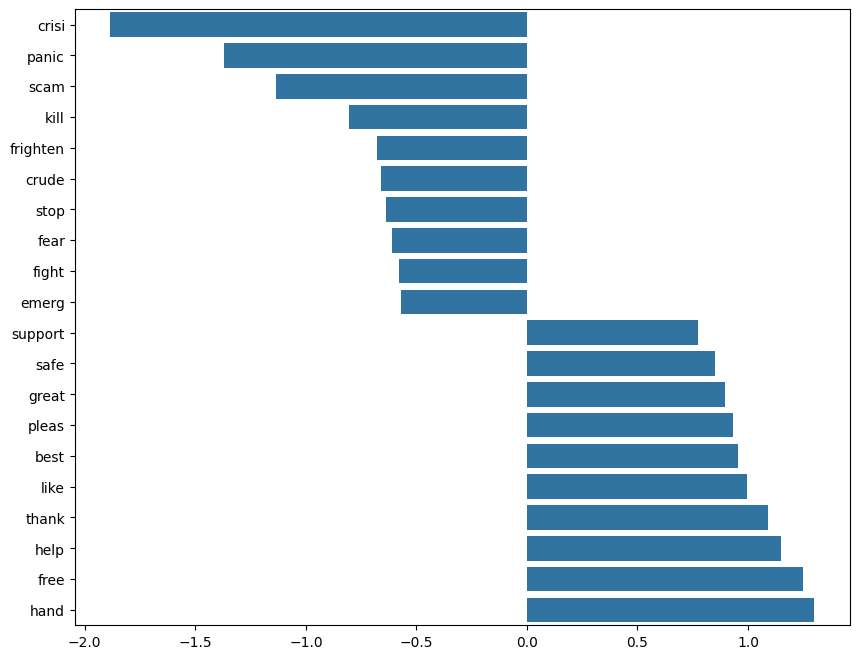

In [193]:
clf_cv = LogisticRegression(max_iter=200, random_state=42)
clf_cv.fit(train_scaled, y_train)
y_pred_train_clf_cv = clf_cv.predict(train_scaled)
y_pred_test_clf_cv = clf_cv.predict(test_scaled)
print("CountVectorizer, train, test:", accuracy_score(y_pred_train_clf_cv, y_train), accuracy_score(y_pred_test_clf_cv, y_test))

features = clf_cv.coef_[0]
top_pos = np.argsort(features)[-10:]
top_neg = np.argsort(features)[:10]

fig, ax = plt.subplots(figsize=(10, 8))
coeff = np.hstack([top_neg, top_pos])
sns.barplot(x=features[coeff], y=[cv.get_feature_names_out()[i] for i in coeff])
plt.show()

**Ответ:** несложно заметить, что все слова отражают суть верно. Негатив складывается из слов: кризис, страх, убийство, что действительно хорошо передает посты с отрицательным контекстом. И наоборот, хорошо отражены слова с положительным контекстом: спасибо, свобода, безопасность, помощь.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [194]:
# -- YOUR CODE HERE --
from collections import Counter

print(len(Counter(df['UserName'])) == len(df['UserName']))
df['UserName'].sample(5)

True


,UserName
11511,17755
14255,21109
16512,23905
13553,20242
12101,18475


UserName просто представляет из себя id пользователя, что не дает нам никакой информации

In [195]:
print(len(Counter(df['ScreenName'])) == len(df['ScreenName']))
df['ScreenName'].sample(5)

True


,ScreenName
10109,61020
30626,86422
7357,57682
25123,79517
3869,53448


In [196]:
print(df['UserName'][0])
print(df['ScreenName'][0])

3800
48752


**Ответ:** оба этих признака дают уникальные значения каждому пользователю, а значит скорее всего они отвечают за id пользователя (или какие-то другие закодированные персонализированные данные), что не дает нам никакой информации для предсказания

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
from datetime import datetime
from datetime import date
# -- YOUR CODE HERE --
def to_date(x):
  data = x.split("-")
  return date(int(data[2]), int(data[1]), int(data[0]))

df['TweetAt'].apply(lambda x: to_date(x))

,TweetAt
0,2020-03-16
1,2020-03-16
2,2020-03-16
3,2020-03-16
4,2020-03-16
...,...
33439,2020-04-14
33440,2020-04-14
33441,2020-04-14
33442,2020-04-14


In [ ]:
df.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
19869,28010,72962,Western Europe,26-03-2020,Just had a thought. After the pandemic can we...,0
16728,24167,69119,Kenya,25-03-2020,Local airfares have dropped by almost half in ...,0
2442,6763,51715,NaN,18-03-2020,"""Just as these politics have delayed the neces...",0
19346,27348,72300,USA,26-03-2020,Capitalism and consumer culture was the virus ...,0
15307,22431,67383,Event: Katsucon 2020,23-03-2020,My grocery store outfit was a black void post ...,0


18046 15398


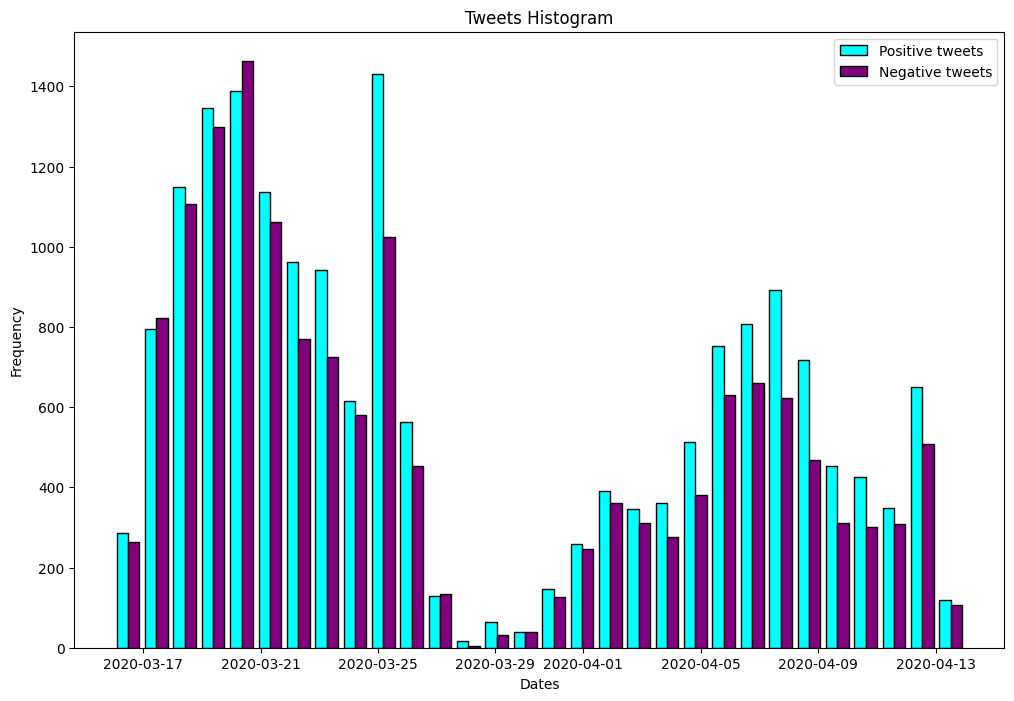

In [197]:
import matplotlib.pyplot as plt
import numpy as np

data_pos = df[df['Sentiment'] == 1]
data_neg = df[df['Sentiment'] == 0]
print(len(data_pos), len(data_neg))
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist([data_pos['TweetAt'].apply(lambda x: to_date(x)), data_neg['TweetAt'].apply(lambda x: to_date(x))], bins=30, color=['cyan', 'Purple'], edgecolor='black')

plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.title('Tweets Histogram')

plt.legend(['Positive tweets', 'Negative tweets'])
plt.show()

**Ответ:** как мне кажется, такой признак тоже плохо поможет для обучения, так как не наблюдается отличительных дат, которые бы показывали значительное различие по количеству положительных и отрицательных твитов



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [198]:
# -- YOUR CODE HERE --
print(len(Counter(train['Location'].dropna())), len(train['Location'].dropna()))
print(train['Location'].dropna().value_counts())
train['Location'].sample(5)

7949 18468
Location
London                      301
United States               295
London, England             274
New York, NY                223
Washington, DC              222
                           ... 
Honolulu, Hawai?i             1
SFO                           1
Cleveland Heights , Ohio      1
SW Florida                    1
 Oman                         1
Name: count, Length: 7949, dtype: int64


,Location
30278,"Fort Mill, South Carolina"
7245,???
2254,Mr AshÃÂs
17278,"Mumbai, India"
24779,United Kingdom


Ну ниче так, уникальных значений в три раза меньше чем всего в целом

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

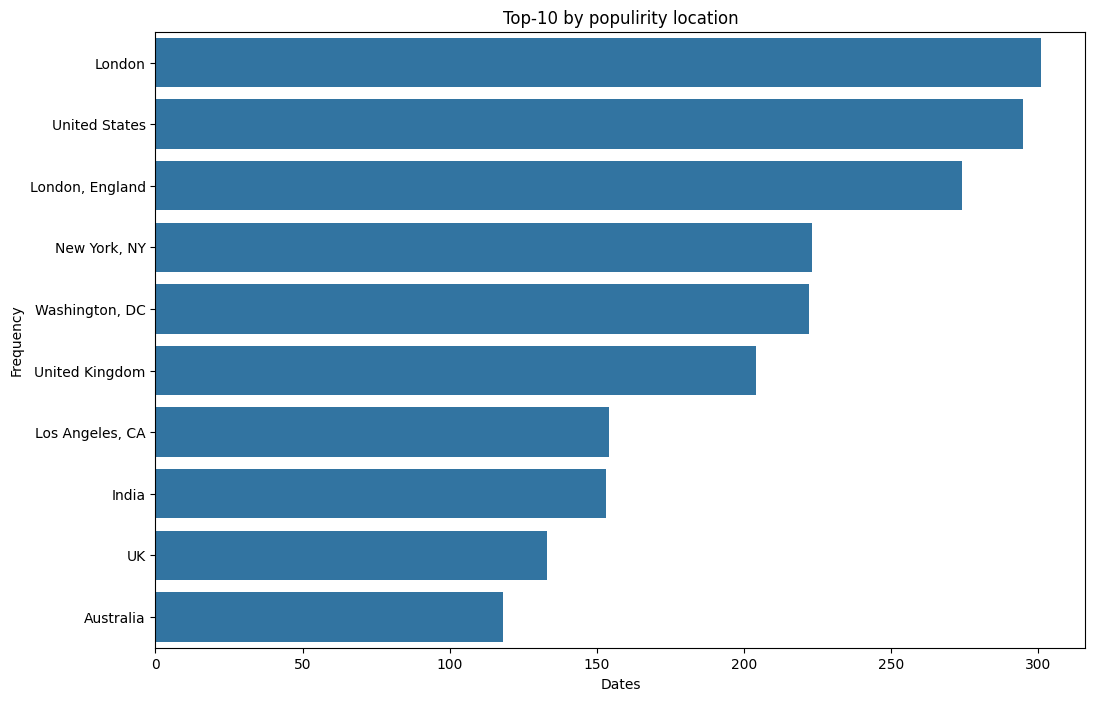

In [199]:
# -- YOUR CODE HERE --
data = train['Location'].dropna().value_counts()[:10]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=data.values, y=data.index)

plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.title('Top-10 by populirity location')

plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [200]:
# -- YOUR CODE HERE --
def to_general_place(x):
  return x.split(',')[-1].strip()

train['WiderLocation'] = train['Location'].dropna().apply(lambda x: to_general_place(x))
print(len(train['WiderLocation'].value_counts()))

4631


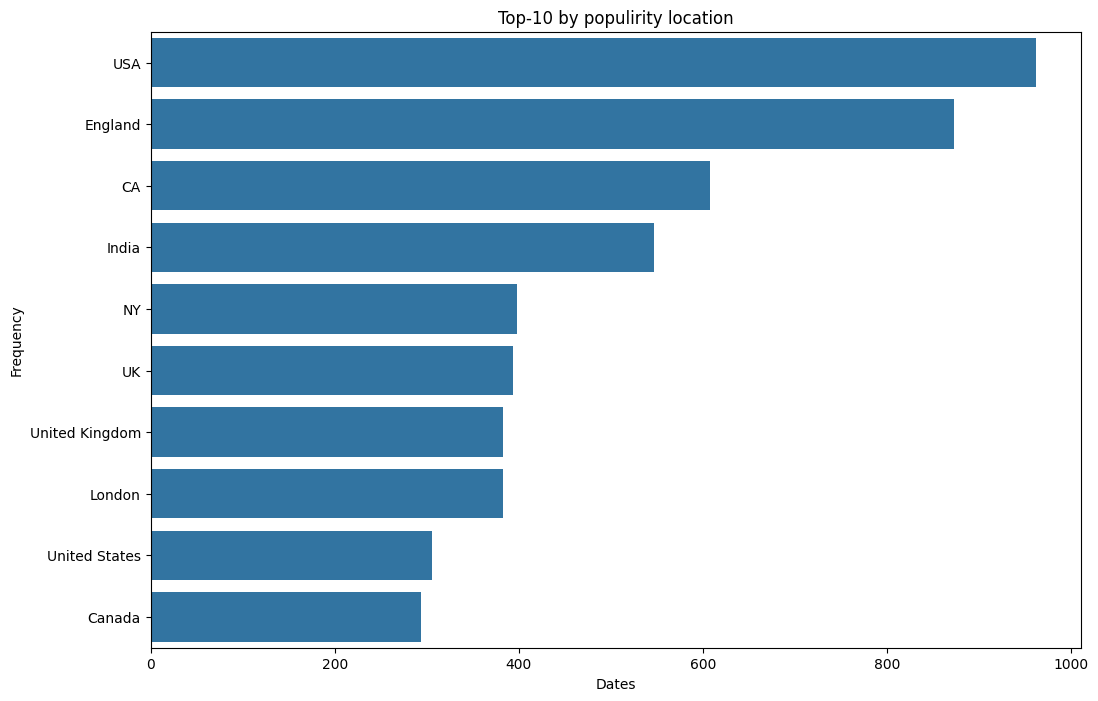

In [201]:
data = train['WiderLocation'].value_counts()[:10]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=data.values, y=data.index)

plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.title('Top-10 by populirity location')

plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [202]:
# -- YOUR CODE HERE --
data = train['WiderLocation'].value_counts()
print(len(data[data > 1]))

988


In [203]:
train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation
16848,24312,69264,????,25-03-2020,Cheryl Idell Chief Research Officer at Enterta...,1,????
20106,28315,73267,"Dubai, United Arab Emirates",26-03-2020,When toilet paper ? sales exceed food ?. ÃÂC...,0,United Arab Emirates
29483,39990,84942,"Washington, DC",09-04-2020,Retailers have made fast adjustments in store ...,1,DC
7784,13260,58212,NaN,20-03-2020,#QUADCITIES: Are you a #smallbusinessowner loo...,1,NaN
25979,35619,80571,Wellington,07-04-2020,Here's an idea: We get the proper journalists ...,1,Wellington


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [204]:
# -- YOUR CODE HERE --
df['WiderLocation'] = df['Location'].dropna().apply(lambda x: to_general_place(x))
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], test_size=0.3, random_state=0)

In [205]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

X_train_WL = df.loc[X_train.index, 'WiderLocation']
X_test_WL = df.loc[X_test.index, 'WiderLocation']

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_WL_encoded = encoder.fit_transform(X_train_WL.values.reshape(-1, 1))
X_test_WL_encoded = encoder.transform(X_test_WL.values.reshape(-1, 1))

X_train_combined = hstack([train_scaled, X_train_WL_encoded])
X_test_combined = hstack([test_scaled, X_test_WL_encoded])

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_combined, y_train)

y_pred = lr.predict(X_test_combined)
accuracy_score(y_test, y_pred)

0.846721148096472

**Ответ:** как мы можем заметить, результатов лучше у нас достичь не получилось, а значит, что Location нам не очень помогло при обучении